<img src="../src/copernicus-logo.png"><span style="margin-left: 40px"></span><img src="../src/cds-logo.jpeg">

# Data Aggregation

In this notebook, we manages data to retrieves them in a time series format. In our case, the final application will manage geo-spatial points given by GPS coordinates and a time series related. We didn't aggregate them in a generalization mechanisms like clustering method because the measurement of a point in a specific time is related to an approximation of 2.5 $km^2$ on a specific area. So, we manipulate information to create time-dependant datasets in each location of the north of Italy and over time in an interval of 10 years (01-01-2011 to 31-12-2021).

## Libraries Dependencies

In [10]:
# installation of dependencies for remote notebook (Jupyter or Google Colab)
# !pip install xarray 
# !pip install netCDF4 dask bottleneck
# !pip install pandas
# !pip install geopandas
# !pip install cdsapi
# !pip instal matplotlib
# !pip install sklearn

# installation of dependencies for local notebook
%pip install xarray 
%pip install netCDF4 dask bottleneck
%pip install pandas
%pip install geopandas
%pip install cdsapi
%pip install matplotlib
%pip install statsmodels
%pip install sklearn

You should consider upgrading via the '/Users/kode/Desktop/Copernicus-river-discharges/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/kode/Desktop/Copernicus-river-discharges/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/kode/Desktop/Copernicus-river-discharges/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/kode/Desktop/Copernicus-river-discharges/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Users/kode/Desktop/Copernicus-river-discharges/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to rest

## Integration between TPI and RDH 

In [2]:
import netCDF4 # to manipulate the original dataset.
import pandas as pd # it is used for the time series management dataset.
import numpy as np # it is used to manage collections of values in the pandas dataframe.
import json # it is used to format data in JSON.
import matplotlib.pyplot as plt # plot results or data distribution.
import seaborn as sns # it is used just for zooming plots
sns.set(rc={'figure.figsize':(15, 8)}) # set the figure default size

In [ ]:
source = open("./samples/map-italy-loc.json", "r") # file with the i.j indexes for the lat lon inside the north Italy rectangle, saved in the same directory of coordinates.
ljson = json.load(source)
source.close()

i_dim = 949 # index of the last element for temperature and precipitation since in a file i goes from 0 to 949 and in the other two it goes from 949 to 0.

# header for the csv file.
header = ['time', 'lat', 'lon', 'discharge', 'temp', 'prec']

# years in the discharge file
d_years = ['2013-2014-2', '2015-2016-3', '2017-2018-4', '2019-2020-5', '2021-2022-6'] 

# years in the temperature and precipitation file
p_t_years = ['2013-8', '2014-9', '2015-10', '2016-11', '2017-12', '2018-13', '2019-14', '2020-15', '2021-16']

# testing years
d_years = ['2021-2022-6']
p_t_years = ['2021-16', '2022-17']

for idf_d in range(0, len(d_years)):
# Edit file path
    nc_d = netCDF4.Dataset('./samples/rdh-'+d_years[idf_d] +'.nc')
    # for each discharge file there are two yers of temperature and precipitation files, so they are indexed adding to the index of the discharge file.
    for idf_d_t in range(0, 2):
        year = p_t_years[idf_d+idf_d_t]
        nc_p = netCDF4.Dataset('./samples/tpi-prec-' + year + '.nc')
        nc_t = netCDF4.Dataset('./samples/tpi-temp-' + year + '.nc')

        # variables that need to be saved, avoiding to have too many indexes later.
        # the time for the timestamp is taken from the precipitation file.
        time_var = nc_p.variables['time']
        dtime = netCDF4.num2date(time_var[:],time_var.units)
        discharge = nc_d.variables['dis06']
        lat = nc_d.variables['latitude']
        lon = nc_d.variables['longitude']
        temp = nc_t.variables['tasAdjust']
        prec = nc_p.variables['prAdjust']
        # for each year write the header of the csv file.
        ds = pd.DataFrame(data = [], columns = header)
        ds.to_csv('italy-dtp-' + year + '.csv', mode='w', index=True)
        # for each timestamp (so for each day) create a new empty dataframe.
        for l in ljson:
            ds = pd.DataFrame(data = [], columns=header)
            len_ds = len(ds)
            for t in range(0, len(dtime)):
                ds.loc[len_ds] = [dtime[t], lat[l[0]][l[1]], lon[l[0]][l[1]], discharge[t+(365*idf_d_t)][l[0]][l[1]], temp[t][i_dim-l[0]][l[1]]-273.15, prec[t][i_dim-l[0]][l[1]]]
                len_ds += 1
            # when the timestamp is done write the dataframe to the file, without the header.
            ds.to_csv('italy-dtp-' + year + '.csv', mode='a', index=True, header=False)

## Display Aggregation Results

We aggregate data from temperatures and precipitations dataset according to discharge locations in a geographical pattern matching. We can filter each point over time by the coordinates over time to defines a specific time series related to a river monitoring location. In addition, we can retrieve data like precipitation, temperature and river discharge directly during the same filtering process.

In [40]:
# number of the identification related to the first year on samples data.
j = 11 
# initialize the dataframe structure according to the data aggregation.
df = pd.DataFrame(columns=['time', 'lat', 'lon', 'discharge', 'temp', 'prec'])

# loading annual dataframes and concatenate with the past history until 2019.
for i in range(2016, 2019):
    tmp = pd.read_csv("../samples/italy-dtp-{}-{}.csv".format(i,j), usecols=['time', 'lat', 'lon', 'discharge', 'temp', 'prec'])
    df = pd.concat([df, tmp])
    j += 1

In [36]:
# print the initial dataset.
df.head()

,time,lat,lon,discharge,temp,prec
0,2016-01-01 12:00:00,44.750378,7.56052,3.988281,6.876062,0.0
1,2016-01-02 12:00:00,44.750378,7.56052,3.983398,5.494745,0.0
2,2016-01-03 12:00:00,44.750378,7.56052,4.030762,3.512628,0.0
3,2016-01-04 12:00:00,44.750378,7.56052,4.053223,3.912592,0.0
4,2016-01-05 12:00:00,44.750378,7.56052,4.042969,5.097375,0.0


The dataframe should be formed by $ n $ locations repeteated $ x $ times wih $ x $ the number of days in the time interval between 01-01-2011 to 31-12-2018. We do not use total dataset because we let the last years as testing set during the data modelling phase.

In [30]:
df_coordinates = df[df['discharge'] != 0]
df_coordinates = df.groupby(by=["lat", "lon"], as_index=False, squeeze=True)
aggregation_functions = {'discharge': 'mean', 'temp': 'mean', 'time': 'first', 'prec' : 'mean'}
df_coordinates = df_coordinates.aggregate(aggregation_functions)

print('-'*40)
print(df_coordinates.head())
print('-'*40)

/var/folders/jd/ysm594m928dfp92zgrlsp1vr0000gn/T/ipykernel_1043/3737088086.py:2: FutureWarning: The `squeeze` parameter is deprecated and will be removed in a future version.
  df_coordinates = df.groupby(by=["lat", "lon"], as_index=False, squeeze=True)


----------------------------------------
         lat       lon  discharge       temp                 time      prec
0  40.519886  8.314602   0.114837  17.094890  2016-01-01 12:00:00  0.000017
1  40.520874  8.373312   0.154153  16.161252  2016-01-01 12:00:00  0.000017
2  40.521824  8.432023   0.352153  15.186535  2016-01-01 12:00:00  0.000018
3  40.522743  8.490736   0.496620  14.969994  2016-01-01 12:00:00  0.000019
4  40.523624   8.54945   0.837323  15.209411  2016-01-01 12:00:00  0.000019
----------------------------------------


[{'type': 'Feature', 'name': 'Fiume Po', 'id': 0, 'geometry': {'type': 'Point', 'coordinates': [7.6197023, 44.841927]}}, {'type': 'Feature', 'name': 'Po', 'id': 1, 'geometry': {'type': 'Point', 'coordinates': [7.673447, 45.068577]}}]


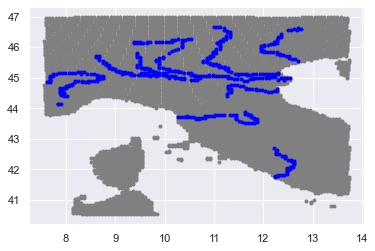

In [28]:
# filter points from original dataset to geojson coordinates related to river positions.
coords = json.load(open('../app/static/data/points.geojson', 'r'))
lats = []
longs = []
for coord in coords['features'][:]:
    sample = coord['geometry']['coordinates']
    lats.append(sample[1])
    longs.append(sample[0])

print(coords['features'][:2])
# plot coordinates
plt.plot(df_coordinates['lon'], df_coordinates['lat'], '.', color='gray')
plt.plot(longs, lats, '.', color='blue')

In [6]:
# number of total rows
print('The current length of the dataframe is: {}'.format(len(df)))

The current length of the dataframe is: 9762072


If we want to analyze the time series related to a specific location, we need to filter the dataframe with only points of a same coordinate. In our case, we will choose a location related to the Po river.

In [41]:
# filter dataframe by coordinates
df = df[df['lat'] == 44.974716]
df = df[df['lon'] == 12.487255]


# print the filtered dataframe
df.head()

,time,lat,lon,discharge,temp,prec
2577372,2016-01-01 12:00:00,44.974716,12.487255,383.9651,1.982721,0.0
2577373,2016-01-02 12:00:00,44.974716,12.487255,377.8164,2.537103,0.0
2577374,2016-01-03 12:00:00,44.974716,12.487255,394.94385,-1.723425,0.000001
2577375,2016-01-04 12:00:00,44.974716,12.487255,394.312,3.574396,0.000001
2577376,2016-01-05 12:00:00,44.974716,12.487255,413.36768,6.951563,0.000003


So, now we can display some time series related to precipitatios, temperatures and discharge changing over time according to the monitored chosen location.

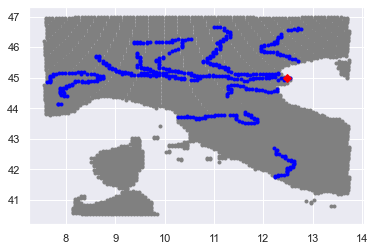

In [44]:
plt.plot(df_coordinates['lon'], df_coordinates['lat'], '.', color='gray')
plt.plot(longs, lats, '.', color='blue')
plt.plot([12.487255],[44.974716], 'D',  color='red')

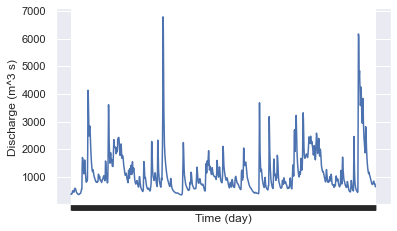

In [45]:
# display the discharge values of the chosen coordinates
df_time = pd.DataFrame()
df_time['value'] = df['discharge']
df_time = df_time.set_index(df['time'])
plt.plot(df_time)
plt.gcf().autofmt_xdate()
plt.tick_params(labelbottom=False, bottom=True)
plt.xlabel('Time (day)')
plt.ylabel('Discharge (m^3 s) ')
plt.show()

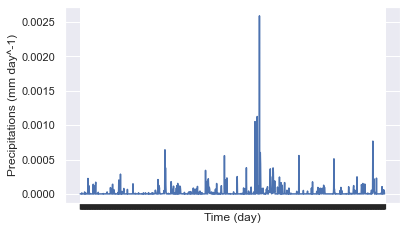

In [46]:
# display the precipitation values of the chosen coordinates
df_prec = pd.DataFrame()
df_prec['value'] = df['prec']
df_prec = df_prec.set_index(df['time'])
plt.plot(df_prec)
plt.gcf().autofmt_xdate()
plt.tick_params(labelbottom=False, bottom=True)
plt.xlabel('Time (day)')
plt.ylabel('Precipitations (mm day^-1)')
plt.show()

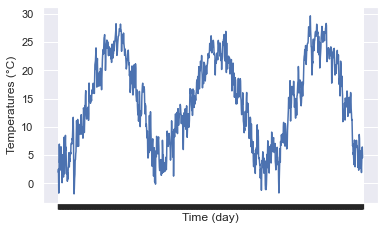

In [47]:
# display the temperature values of the chosen coordinates
df_temp = pd.DataFrame()
df_temp['value'] = df['temp']
df_temp = df_temp.set_index(df['time'])
plt.plot(df_temp)
plt.gcf().autofmt_xdate()
plt.tick_params(labelbottom=False, bottom=True)
plt.xlabel('Time (day)')
plt.ylabel('Temperatures (°C)')
plt.show()

A starting evaluation of data distribution over time can give us some information about the temperature seasonality over years and the not-stationary features for the precipitations and discharges. We will evaluate all of them during the data correlation phase with some statistical analysis to confirm or not these hypothesis.